This notebook explores: 
* The amount of missing data (due to errors, or information that wasn't captured in older versions)
* The number of tokens used for prompts and cost for each tool 

TLDR:

Errors 

1. We analysed errors over time. Most of the errors recently came from openai-gpt-3.5-turbo-instruct. Specifically, it was a parsing error. Maybe this particular model is worse at following the instructions on output format. Using function calling might help here.

Cost

2. Claude is about 10X as expensive as GPT-3.5-turbo. 
3. Using online search uses about twice as many tokens (doubles the cost).
4. Summarizing the whole web pages costs 2.5X more than using just the first 300 words. 

Scraping

5. (To test for script data but true for autocast) High fraction of scraped URLs are not useful because of paywalls, captchas etc. It remains to be seen how the situation is for live search results.

In [1]:
from costing import costing
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
pd.set_option("display.precision", 4)
pd.set_option('display.max_columns', None)

plt.style.use('ggplot')

### Load data

In [2]:
# csv ending in _old is the original data
# others are extracted using the concurrent script

dataset = pd.read_csv("./data/dataset.csv")
requests = pd.read_csv("./data/requests.csv")
tools = pd.read_csv("./data/tools.csv")

# drop duplicates by request_id
dataset = dataset.drop_duplicates(subset=['request_id'])
requests = requests.drop_duplicates(subset=['request_id'])
tools = tools.drop_duplicates(subset=['request_id'])

### Error calls

In [3]:
tools['request_block_bucket'] = tools['request_block'].apply(lambda x: x // 100_000)

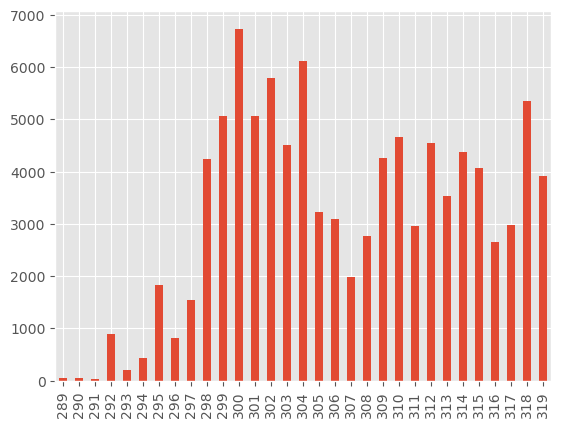

In [4]:
tools['request_block_bucket'].value_counts().sort_index().plot(kind='bar')

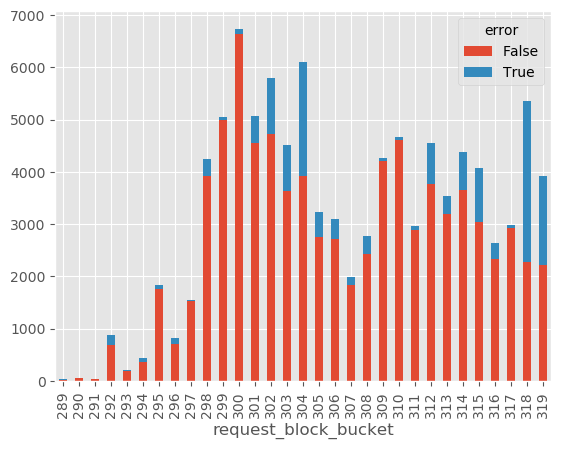

In [5]:
tools.groupby(['request_block_bucket', 'error']).size().unstack().plot(kind='bar', stacked=True)

In [6]:
# number of requests per bucket to each tool
tools.groupby(['tool', 'request_block_bucket']).count()['request_id'].unstack().fillna(0).loc[:, 300:]

request_block_bucket,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319
tool,,,,,,,,,,,,,,,,,,,,
claude-prediction-offline,0.0,216.0,906.0,694.0,1090.0,651.0,733.0,152.0,1.0,3.0,2.0,18.0,0.0,0.0,0.0,18.0,0.0,0.0,0.0,0.0
claude-prediction-online,0.0,420.0,976.0,699.0,2669.0,399.0,170.0,84.0,0.0,2.0,4.0,39.0,226.0,248.0,698.0,985.0,250.0,285.0,261.0,233.0
normal-sme-generator,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
openai,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
openai-gpt-3.5-turbo-instruct,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3006.0,1667.0
prediction-offline,10.0,534.0,969.0,693.0,414.0,502.0,298.0,58.0,0.0,0.0,9.0,25.0,0.0,1.0,0.0,8.0,0.0,1.0,0.0,0.0
prediction-offline-sme,0.0,177.0,949.0,825.0,463.0,496.0,762.0,483.0,0.0,0.0,24.0,21.0,0.0,1.0,0.0,5.0,0.0,0.0,0.0,0.0
prediction-online,6657.0,3381.0,968.0,753.0,1027.0,824.0,702.0,701.0,1459.0,2202.0,2347.0,1400.0,413.0,44.0,26.0,76.0,52.0,6.0,0.0,0.0
prediction-online-sme,44.0,333.0,1032.0,847.0,448.0,365.0,423.0,262.0,1310.0,2050.0,2278.0,1458.0,3273.0,3108.0,3638.0,2911.0,2299.0,2688.0,2085.0,2023.0


In [7]:
# number of non-error requests per bucket to each tool
tools[tools['error'] == False].groupby(['tool', 'request_block_bucket']).count()['request_id'].unstack().fillna(0).loc[:, 300:]

request_block_bucket,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319
tool,,,,,,,,,,,,,,,,,,,,
claude-prediction-offline,0.0,143.0,663.0,423.0,717.0,518.0,565.0,112.0,1.0,3.0,1.0,2.0,0.0,0.0,0.0,18.0,0.0,0.0,0.0,0.0
claude-prediction-online,0.0,103.0,177.0,138.0,867.0,165.0,75.0,40.0,0.0,0.0,1.0,3.0,15.0,7.0,2.0,0.0,15.0,240.0,196.0,209.0
prediction-offline,10.0,529.0,964.0,687.0,414.0,470.0,295.0,58.0,0.0,0.0,9.0,25.0,0.0,1.0,0.0,8.0,0.0,1.0,0.0,0.0
prediction-offline-sme,0.0,175.0,942.0,817.0,462.0,462.0,700.0,480.0,0.0,0.0,24.0,21.0,0.0,1.0,0.0,5.0,0.0,0.0,0.0,0.0
prediction-online,6578.0,3285.0,958.0,743.0,1020.0,784.0,679.0,684.0,1281.0,2180.0,2321.0,1390.0,410.0,44.0,26.0,76.0,50.0,6.0,0.0,0.0
prediction-online-sme,42.0,317.0,1015.0,830.0,444.0,347.0,404.0,257.0,1152.0,2029.0,2257.0,1445.0,3242.0,3102.0,3622.0,2905.0,2253.0,2678.0,2079.0,2007.0
prediction-online-summarized-info,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,105.0,44.0,8.0,25.0,20.0,1.0,1.0,0.0
prediction-sentence-embedding-bold,0.0,0.0,0.0,0.0,0.0,0.0,0.0,115.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
prediction-sentence-embedding-conservative,0.0,0.0,0.0,0.0,0.0,0.0,0.0,94.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# number of error requests per bucket to each tool
tools[tools['error'] == True].groupby(['tool', 'request_block_bucket']).count()['request_id'].unstack().fillna(0).loc[:, 300:]

request_block_bucket,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319
tool,,,,,,,,,,,,,,,,,,,,
claude-prediction-offline,0.0,73.0,243.0,271.0,373.0,133.0,168.0,40.0,0.0,0.0,1.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
claude-prediction-online,0.0,317.0,799.0,561.0,1802.0,234.0,95.0,44.0,0.0,2.0,3.0,36.0,211.0,241.0,696.0,985.0,235.0,45.0,65.0,24.0
normal-sme-generator,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
openai,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
openai-gpt-3.5-turbo-instruct,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3006.0,1667.0
prediction-offline,0.0,5.0,5.0,6.0,0.0,32.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
prediction-offline-sme,0.0,2.0,7.0,8.0,1.0,34.0,62.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
prediction-online,79.0,96.0,10.0,10.0,7.0,40.0,23.0,17.0,178.0,22.0,26.0,10.0,3.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
prediction-online-sme,2.0,16.0,17.0,17.0,4.0,18.0,19.0,5.0,158.0,21.0,21.0,13.0,31.0,6.0,16.0,6.0,46.0,10.0,6.0,16.0


In [9]:
err = tools.groupby(['tool', 'request_block_bucket', 'error']).count()['request_id'].unstack().unstack().fillna(0)
(err[False] / (err[False] + err[True])).fillna(0).loc[:, 300:]

request_block_bucket,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319
tool,,,,,,,,,,,,,,,,,,,,
claude-prediction-offline,0.0000,0.6620,0.7318,0.6095,0.6578,0.7957,0.7708,0.7368,1.0000,1.0000,0.5000,0.1111,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000
claude-prediction-online,0.0000,0.2452,0.1814,0.1974,0.3248,0.4135,0.4412,0.4762,0.0000,0.0000,0.2500,0.0769,0.0664,0.0282,0.0029,0.0000,0.0600,0.8421,0.7510,0.8970
normal-sme-generator,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
openai,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
openai-gpt-3.5-turbo-instruct,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
prediction-offline,1.0000,0.9906,0.9948,0.9913,1.0000,0.9363,0.9899,1.0000,0.0000,0.0000,1.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000
prediction-offline-sme,0.0000,0.9887,0.9926,0.9903,0.9978,0.9315,0.9186,0.9938,0.0000,0.0000,1.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000
prediction-online,0.9881,0.9716,0.9897,0.9867,0.9932,0.9515,0.9672,0.9757,0.8780,0.9900,0.9889,0.9929,0.9927,1.0000,1.0000,1.0000,0.9615,1.0000,0.0000,0.0000
prediction-online-sme,0.9545,0.9520,0.9835,0.9799,0.9911,0.9507,0.9551,0.9809,0.8794,0.9898,0.9908,0.9911,0.9905,0.9981,0.9956,0.9979,0.9800,0.9963,0.9971,0.9921


In [10]:
tools[tools['tool'].str.contains('instruct')].groupby(['request_block_bucket', 'error_message']).count()['request_id'].unstack()

error_message,Invalid response from tool,Response parsing error
request_block_bucket,,
318,1.0,3005.0
319,NaN,1667.0


In [11]:
tools.groupby(['request_block_bucket', 'error_message']).count()['request_id'].unstack().T

request_block_bucket,289,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319
error_message,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"""Missing key in PredictionResponse: 'p_yes'""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
Invalid response from tool,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,320.0,57.0,107.0,400.0,764.0,545.0,1451.0,294.0,171.0,83.0,335.0,46.0,50.0,42.0,599.0,139.0,679.0,1030.0,308.0,53.0,63.0,36.0
Invalid value in PredictionResponse: could not convert string to float: 'Error: More than two outcomes',NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
Response parsing error,31.0,4.0,203.0,3.0,68.0,79.0,117.0,1.0,NaN,NaN,NaN,109.0,317.0,328.0,736.0,197.0,201.0,56.0,2.0,NaN,1.0,33.0,185.0,193.0,48.0,1.0,2.0,6.0,3014.0,1671.0


Learnings
- most of the request are going to prediction-online-sme
- most of the errors recently came from openai-gpt-3.5-turbo-instruct	
- specifically, it was parsing error (would function calling help? or instruct model do not follow instructions that well?)

### Costing

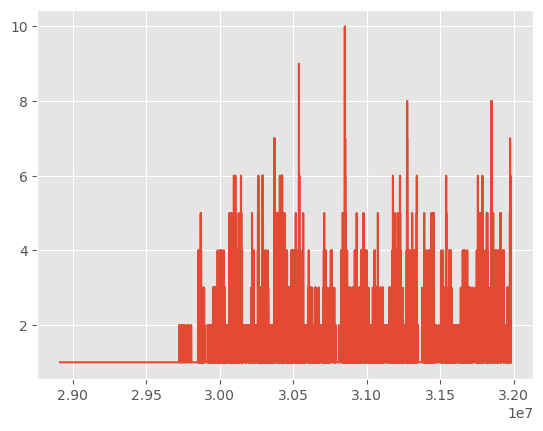

In [12]:
tools['deliver_block'].value_counts().sort_index().plot()

There is less data on new `tools` because `old_mech` didnt save the full prompt

In [13]:
# add full_prompt to dataset
include_tools = [
    'prediction-offline',
    'prediction-online',
    'prediction-online-summarized-info',
    'prediction-offline-sme',
    'prediction-online-sme',
    'claude-prediction-online',
    'claude-prediction-offline'
]

tools = tools[tools.tool.isin(include_tools)]

# Select only non na prompt_response
tools = tools[tools.prompt_response.notna()]

Below we calculate the number of words in the request prompts and response prompts. 

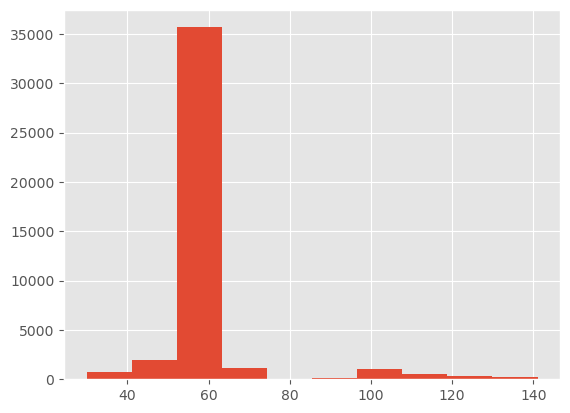

In [14]:
# prompt_request is the from the prompt from trader to mech (tool)
tools['prompt_request'].apply(lambda x: len(x.split(' '))).hist()

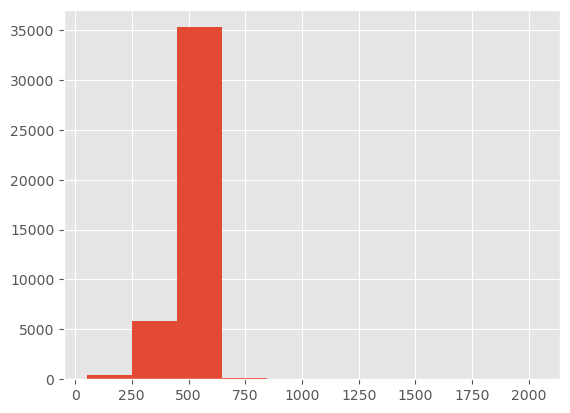

In [15]:
# prompt_response is the full prompt used by the mech (tool)
tools['prompt_response'].apply(lambda x: len(x.split(' '))).hist()

Below, we calculate the number of tokens in the request prompts and response prompts.  

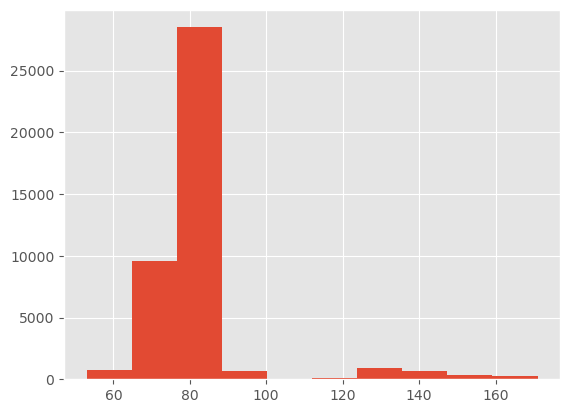

In [16]:
tools['prompt_request_token'] = tools['prompt_request'].apply(lambda x: costing.TokenCounter.count_tokens(x, model='gpt-3.5-turbo'))
tools['prompt_request'].apply(lambda x: costing.TokenCounter.count_tokens(x, model='gpt-3.5-turbo')).hist()

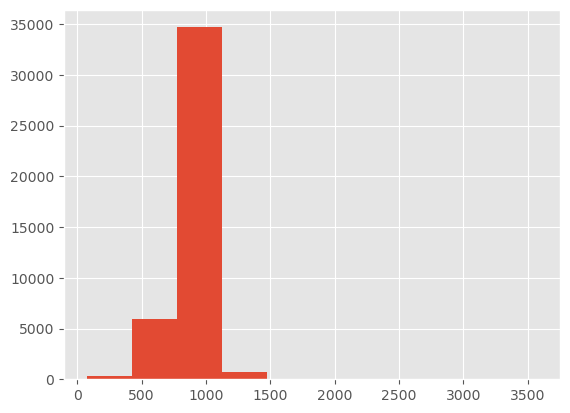

In [17]:
tools['prompt_response_token'] = tools['prompt_response'].apply(lambda x: costing.TokenCounter.count_tokens(x, model='gpt-3.5-turbo'))
tools['prompt_response_token'].hist()

Below, we show the number of response prompt tokens used for each tool. 

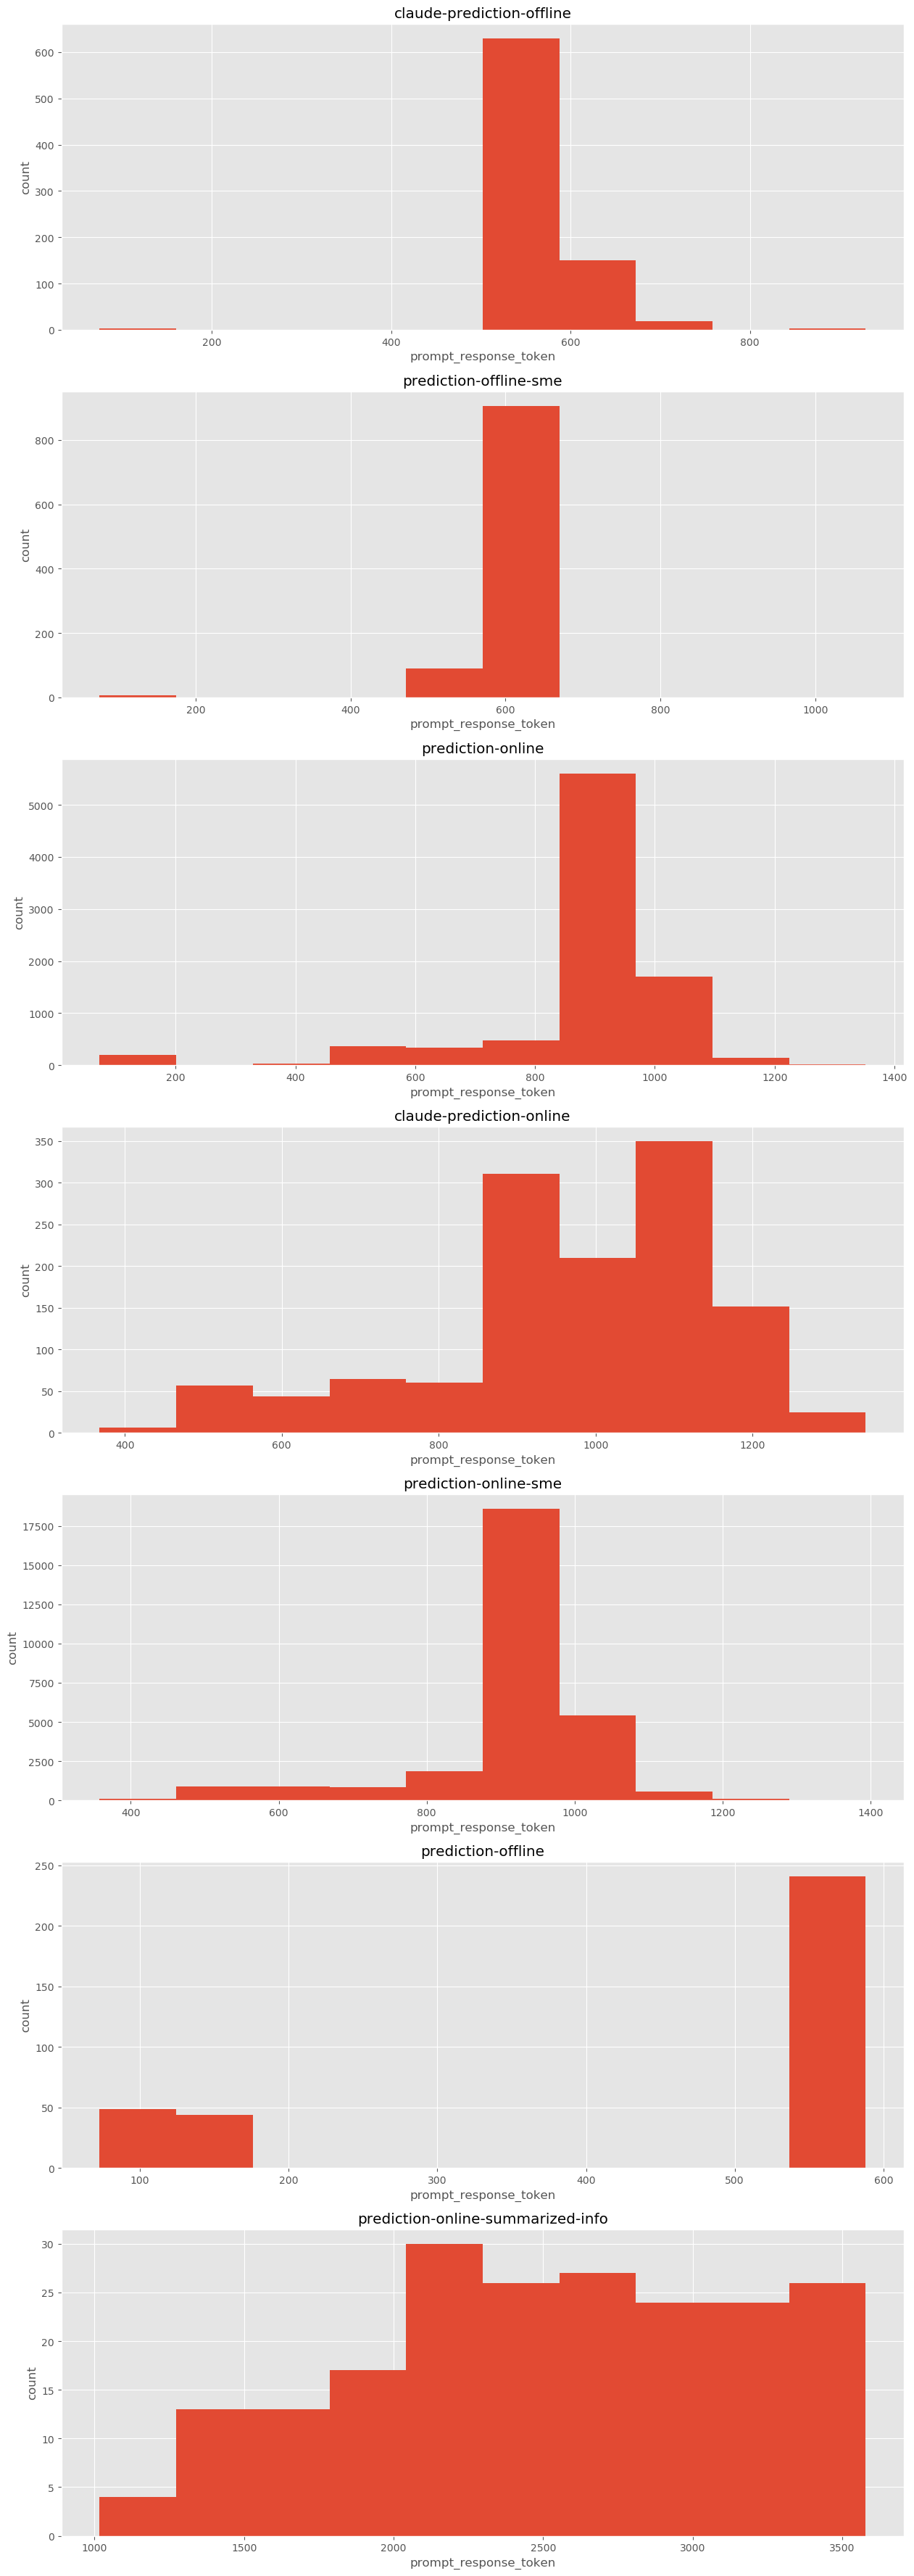

In [18]:
fig, axes = plt.subplots(7, 1, figsize=(15, 45))

for i, tool in enumerate(tools['tool'].unique()):
    tools[tools['tool'] == tool]['prompt_response_token'].hist(ax=axes[i])
    axes[i].set_title(tool)
    axes[i].set_xlabel('prompt_response_token')
    axes[i].set_ylabel('count')

Below is the mean prompt response tokens for each tool, sorted by most tokens. 

In [19]:
tools.groupby('tool')['prompt_response_token'].mean().sort_values(ascending=False)

tool
prediction-online-summarized-info    2520.2059
claude-prediction-online              975.4086
prediction-online-sme                 916.0813
prediction-online                     888.2511
claude-prediction-offline             589.0620
prediction-offline-sme                583.7930
prediction-offline                    443.2754
Name: prompt_response_token, dtype: float64

In [20]:
for data in tqdm(tools.iterrows(), total=len(tools), desc='Counting costs'):
    tool = data[1].tool
    prompt = data[1].prompt_response
    response = None
    counter = costing.CostCounter(tool=tool, prediciton_prompt=prompt, final_response=response)
    cost = counter.run()
    tools.loc[data[0], 'cost'] = cost
    tools.loc[data[0], 'input_tokens'] = counter.total_input_tokens
    tools.loc[data[0], 'output_tokens'] = counter.total_output_tokens

Counting costs: 100%|██████████| 41790/41790 [01:41<00:00, 411.21it/s]


The below tables show more about the distribution of the overall cost for each tool.

In [21]:
tools.groupby('tool').cost.aggregate([
    'min', 'max', 'mean', 'median',
    lambda x: np.percentile(x, 75), 
    lambda x: np.percentile(x, 90)
]).rename(columns={
    '<lambda_0>': '75th percentile',
    '<lambda_1>': '90th percentile'
}).sort_values(by='90th percentile', ascending=False)

,min,max,mean,median,75th percentile,90th percentile
tool,,,,,,
claude-prediction-online,0.0389,0.0556,0.0490,0.0492,0.0514,0.0520
prediction-online-summarized-info,0.0278,0.0329,0.0308,0.0308,0.0318,0.0324
prediction-online-sme,0.0274,0.0305,0.0291,0.0291,0.0292,0.0294
prediction-online,0.0259,0.0284,0.0275,0.0276,0.0276,0.0277
claude-prediction-offline,0.0030,0.0103,0.0075,0.0074,0.0074,0.0077
prediction-offline-sme,0.0010,0.0029,0.0020,0.0020,0.0020,0.0021
prediction-offline,0.0003,0.0008,0.0006,0.0008,0.0008,0.0008


In [22]:
tools.groupby('tool').input_tokens.aggregate([
    'min', 'max', 'mean', 'median',
    lambda x: np.percentile(x, 75), 
    lambda x: np.percentile(x, 90)
]).rename(columns={
    '<lambda_0>': '75th percentile',
    '<lambda_1>': '90th percentile'
}).sort_values(by='90th percentile', ascending=False)

,min,max,mean,median,75th percentile,90th percentile
tool,,,,,,
prediction-online-summarized-info,2353.0,7475.0,5359.4118,5380.0,6433.5,7007.0
prediction-online-sme,1802.0,4907.0,3476.2438,3539.0,3638.0,3767.0
claude-prediction-online,1143.0,3221.0,2402.5430,2426.0,2697.0,2781.0
prediction-online,466.0,3023.0,2095.5241,2177.0,2241.0,2323.0
prediction-offline-sme,562.0,2539.0,1576.5920,1563.0,1571.0,1686.2
claude-prediction-offline,76.0,987.0,632.2305,624.0,629.0,664.0
prediction-offline,73.0,588.0,443.2754,569.5,577.0,580.0


In [23]:
tools.groupby('tool').output_tokens.aggregate([
    'min', 'max', 'mean', 'median',
    lambda x: np.percentile(x, 75), 
    lambda x: np.percentile(x, 90)
]).rename(columns={
    '<lambda_0>': '75th percentile',
    '<lambda_1>': '90th percentile'
}).sort_values(by='90th percentile', ascending=False)

,min,max,mean,median,75th percentile,90th percentile
tool,,,,,,
prediction-online-sme,300.0,300.0,300.0,300.0,300.0,300.0
claude-prediction-online,200.0,200.0,200.0,200.0,200.0,200.0
prediction-offline-sme,200.0,200.0,200.0,200.0,200.0,200.0
prediction-online,200.0,200.0,200.0,200.0,200.0,200.0
prediction-online-summarized-info,200.0,200.0,200.0,200.0,200.0,200.0
claude-prediction-offline,100.0,100.0,100.0,100.0,100.0,100.0
prediction-offline,100.0,100.0,100.0,100.0,100.0,100.0
